# Cleaning the generated file

## Import stuff

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import time
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [76]:
!pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [77]:
from imblearn.over_sampling import SMOTE


In [78]:
# Step 1: Load the data
#data = pd.read_csv("physionetdotorg/files/tappy/1/processed_10082024.csv")
data = pd.read_csv("physionetdotorg/files/tappy/1/processed_17082024.csv")

print(f"Initial data shape: {data.shape}")

Initial data shape: (422, 40)


In [79]:
data.head

<bound method NDFrame.head of         UserKey  L-LL-FlightTime  L-RL-FlightTime  L-SL-FlightTime  \
0    MG8XVA5BFA       115.730815       104.111354       111.314657   
1    SGT8K5GXG0       225.171028       211.668546       257.633333   
2    VIAXR21TSC       216.275629       162.807451       174.102771   
3    EX8J9DGRSY       340.091096       543.184524       470.261538   
4    NPACI6EW26       140.718128       140.051945       167.876490   
..          ...              ...              ...              ...   
417  95S93AXF86       177.549493       135.998049       236.548736   
418  EF9XEFXPBN       202.318062       151.596662       210.148878   
419  HSOCXZDCZM       200.462457       310.367329       282.429773   
420  3MZWDTW7CC       217.409451       239.994912       246.797566   
421  MAKSYM0000       189.420800       124.586429       174.632667   

     R-LR-FlightTime  R-RR-FlightTime  R-SR-FlightTime  S-LS-FlightTime  \
0         106.469173       109.280449       112.688293

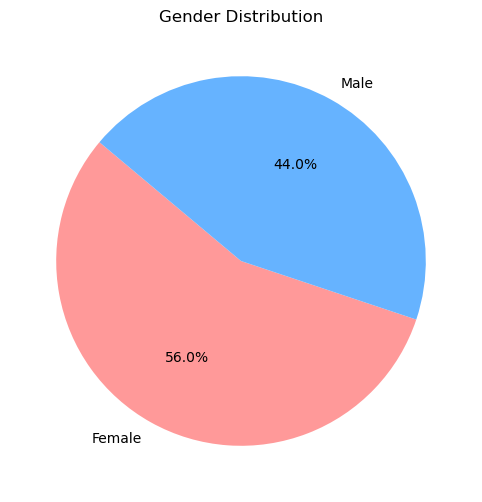

In [80]:
gender_counts = data['Gender'].value_counts()

labels = ['Female', 'Male']
sizes = gender_counts

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=140)
plt.title('Gender Distribution')
plt.show()

## First have to, again, convert stuff

In [81]:
data.dtypes

UserKey              object
L-LL-FlightTime     float64
L-RL-FlightTime     float64
L-SL-FlightTime     float64
R-LR-FlightTime     float64
R-RR-FlightTime     float64
R-SR-FlightTime     float64
S-LS-FlightTime     float64
S-RS-FlightTime     float64
S-SS-FlightTime     float64
L-LL-HoldTime       float64
L-RL-HoldTime       float64
L-SL-HoldTime       float64
R-LR-HoldTime       float64
R-RR-HoldTime       float64
R-SR-HoldTime       float64
S-LS-HoldTime       float64
S-RS-HoldTime       float64
S-SS-HoldTime       float64
L-LL-LatencyTime    float64
L-RL-LatencyTime    float64
L-SL-LatencyTime    float64
R-LR-LatencyTime    float64
R-RR-LatencyTime    float64
R-SR-LatencyTime    float64
S-LS-LatencyTime    float64
S-RS-LatencyTime    float64
S-SS-LatencyTime    float64
BirthYear            object
Gender               object
Tremors              object
DiagnosisYear        object
Sided                object
UPDRS                object
Impact               object
Levadopa            

In [82]:

data["Gender"]

0       Female
1         Male
2       Female
3         Male
4       Female
        ...   
417     Female
418     Female
419        NaN
420     Female
421       Male
Name: Gender, Length: 422, dtype: object

### Encode label

In [83]:
label_encoder = LabelEncoder()

data['Parkinsons'] = label_encoder.fit_transform(data['Parkinsons'])


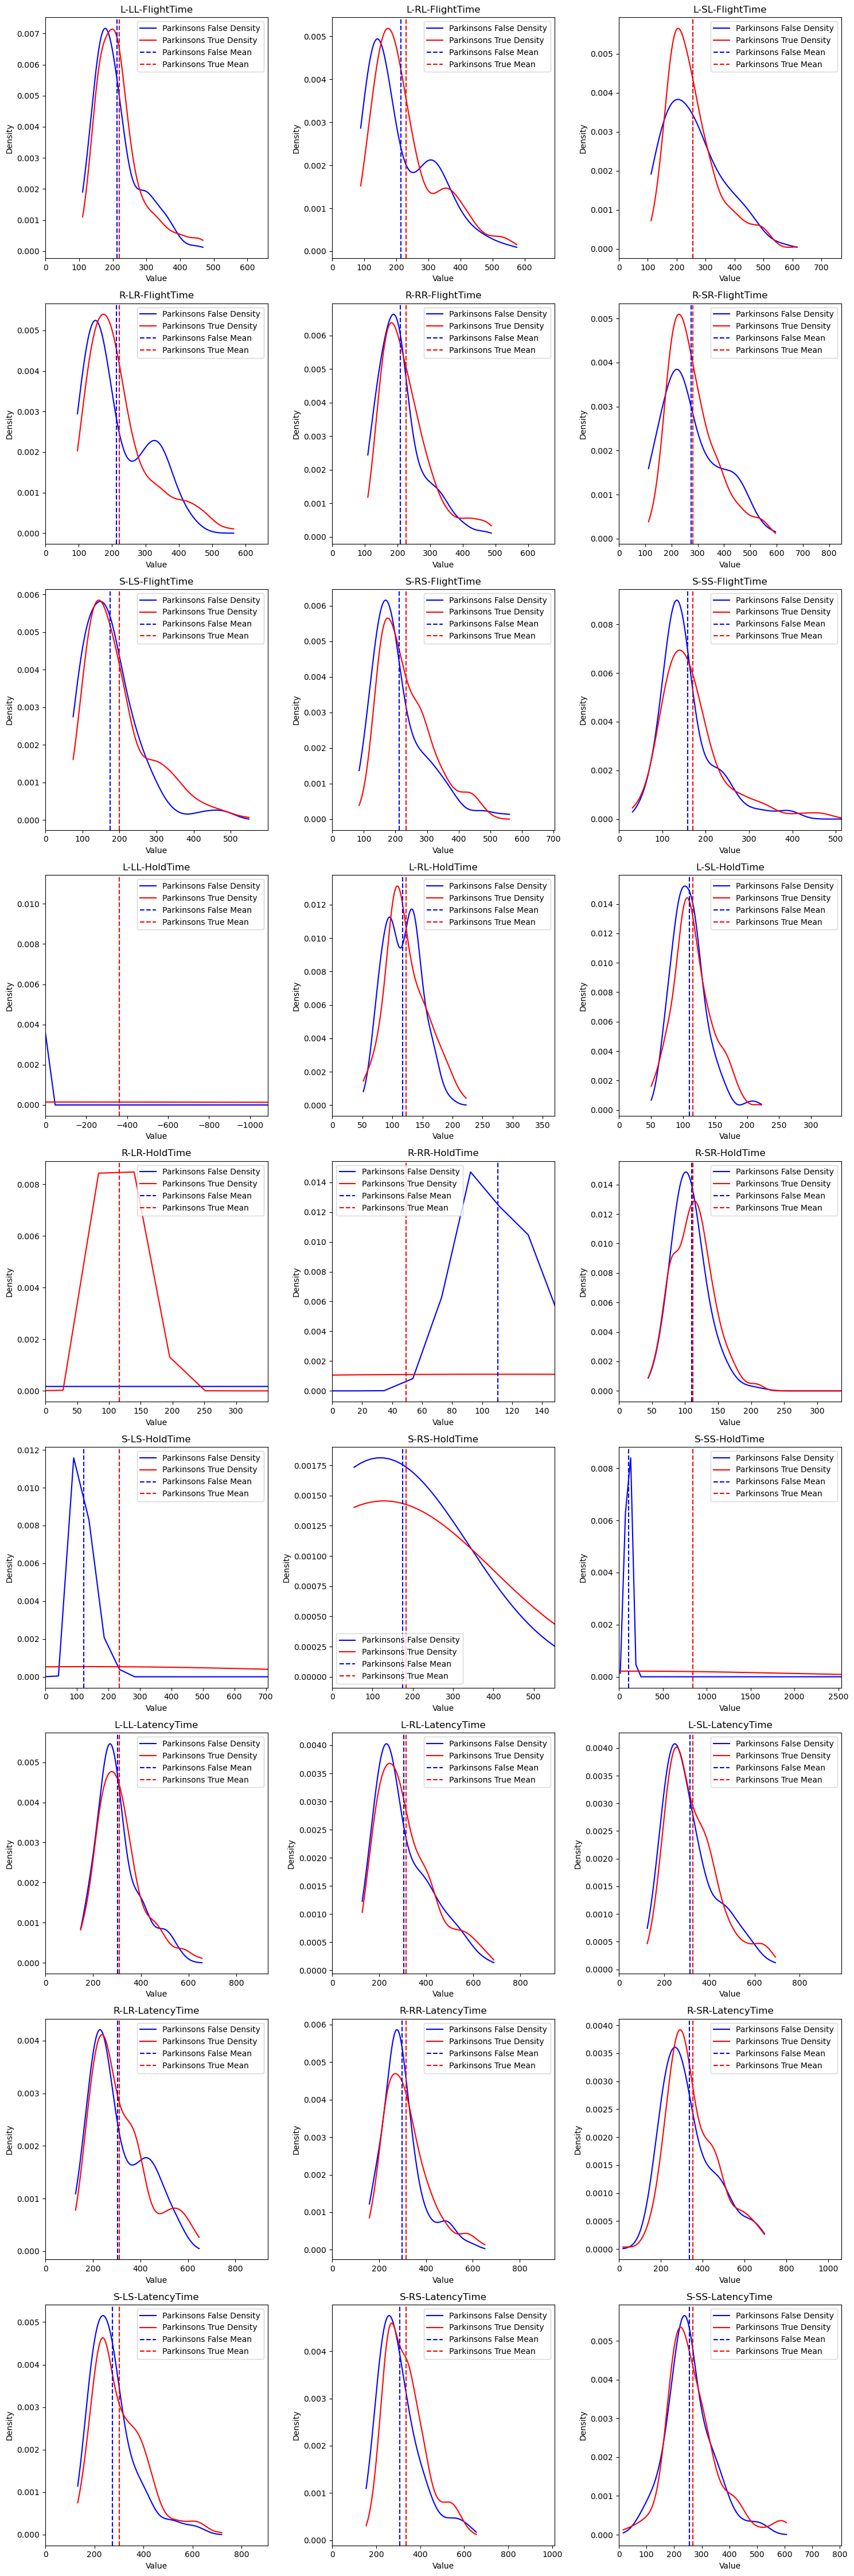

In [84]:
import os

# List of all numeric columns to process
numeric_columns = [
    'L-LL-FlightTime', 'L-RL-FlightTime', 'L-SL-FlightTime',
    'R-LR-FlightTime', 'R-RR-FlightTime', 'R-SR-FlightTime',
    'S-LS-FlightTime', 'S-RS-FlightTime', 'S-SS-FlightTime',
    'L-LL-HoldTime', 'L-RL-HoldTime', 'L-SL-HoldTime',
    'R-LR-HoldTime', 'R-RR-HoldTime', 'R-SR-HoldTime',
    'S-LS-HoldTime', 'S-RS-HoldTime', 'S-SS-HoldTime',
    'L-LL-LatencyTime', 'L-RL-LatencyTime', 'L-SL-LatencyTime',
    'R-LR-LatencyTime', 'R-RR-LatencyTime', 'R-SR-LatencyTime',
    'S-LS-LatencyTime', 'S-RS-LatencyTime', 'S-SS-LatencyTime'
]

# Determine the number of rows and columns for subplots
n_cols = 3  # Number of columns in the subplot grid
n_rows = int(np.ceil(len(numeric_columns) / n_cols))  # Number of rows needed

# Set up the figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# First loop for displaying all graphs together
for i, col in enumerate(numeric_columns):
    data_false = data[data["Parkinsons"] == 0][col].dropna().to_numpy()
    data_true = data[data["Parkinsons"] == 1][col].dropna().to_numpy()

    # Compute KDE
    kde_false = gaussian_kde(data_false, bw_method='scott')
    kde_true = gaussian_kde(data_true, bw_method='scott')

    # Compute means
    mean_false = np.mean(data_false)
    mean_true = np.mean(data_true)

    # Generate points for KDE plot
    x_vals = np.linspace(min(data_false.min(), data_true.min()), max(data_false.max(), data_true.max()), 1000)

    # Plot KDE on the respective subplot
    axes[i].plot(x_vals, kde_false(x_vals), color='blue', label='Parkinsons False Density')
    axes[i].plot(x_vals, kde_true(x_vals), color='red', label='Parkinsons True Density')

    # Plot mean lines
    axes[i].axvline(mean_false, color='blue', linestyle='--', label='Parkinsons False Mean')
    axes[i].axvline(mean_true, color='red', linestyle='--', label='Parkinsons True Mean')

    # Set plot labels and title
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].set_xlim(0, (data_true.mean() * 3))

# Remove any unused subplots
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

for i, col in enumerate(numeric_columns):
    # Create a new figure for each plot
    fig, ax = plt.subplots(figsize=(6, 4))

    data_false = data[data["Parkinsons"] == 0][col].dropna().to_numpy()
    data_true = data[data["Parkinsons"] == 1][col].dropna().to_numpy()

    # Compute KDE
    kde_false = gaussian_kde(data_false, bw_method='scott')
    kde_true = gaussian_kde(data_true, bw_method='scott')

    # Compute means
    mean_false = np.mean(data_false)
    mean_true = np.mean(data_true)

    # Generate points for KDE plot
    x_vals = np.linspace(min(data_false.min(), data_true.min()), max(data_false.max(), data_true.max()), 1000)

    # Plot KDE
    ax.plot(x_vals, kde_false(x_vals), color='blue', label='Parkinsons False Density')
    ax.plot(x_vals, kde_true(x_vals), color='red', label='Parkinsons True Density')

    # Plot mean lines
    ax.axvline(mean_false, color='blue', linestyle='--', label='Parkinsons False Mean')
    ax.axvline(mean_true, color='red', linestyle='--', label='Parkinsons True Mean')

    # Set plot labels and title
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_xlim(0, (data_true.mean() * 3))

    # Save the figure
    save_path = os.path.join(f'{col}_Density_Plot.png')
    fig.savefig(save_path)

    # Close the figure to avoid display
    plt.close(fig)


In [85]:
data.columns

Index(['UserKey', 'L-LL-FlightTime', 'L-RL-FlightTime', 'L-SL-FlightTime',
       'R-LR-FlightTime', 'R-RR-FlightTime', 'R-SR-FlightTime',
       'S-LS-FlightTime', 'S-RS-FlightTime', 'S-SS-FlightTime',
       'L-LL-HoldTime', 'L-RL-HoldTime', 'L-SL-HoldTime', 'R-LR-HoldTime',
       'R-RR-HoldTime', 'R-SR-HoldTime', 'S-LS-HoldTime', 'S-RS-HoldTime',
       'S-SS-HoldTime', 'L-LL-LatencyTime', 'L-RL-LatencyTime',
       'L-SL-LatencyTime', 'R-LR-LatencyTime', 'R-RR-LatencyTime',
       'R-SR-LatencyTime', 'S-LS-LatencyTime', 'S-RS-LatencyTime',
       'S-SS-LatencyTime', 'BirthYear', 'Gender', 'Tremors', 'DiagnosisYear',
       'Sided', 'UPDRS', 'Impact', 'Levadopa', 'DA', 'MAOB', 'Other',
       'Parkinsons'],
      dtype='object')

## Deal with Columns

### Check if there are empty fields or nans

In [86]:
# List of columns to check
columns_to_check = [
    'L-LL-FlightTime', 'L-RL-FlightTime', 'L-SL-FlightTime',
    'R-LR-FlightTime', 'R-RR-FlightTime', 'R-SR-FlightTime',
    'S-LS-FlightTime', 'S-RS-FlightTime', 'S-SS-FlightTime',
    'L-LL-HoldTime', 'L-RL-HoldTime', 'L-SL-HoldTime', 'R-LR-HoldTime',
    'R-RR-HoldTime', 'R-SR-HoldTime', 'S-LS-HoldTime', 'S-RS-HoldTime',
    'S-SS-HoldTime', 'L-LL-LatencyTime', 'L-RL-LatencyTime',
    'L-SL-LatencyTime', 'R-LR-LatencyTime', 'R-RR-LatencyTime',
    'R-SR-LatencyTime', 'S-LS-LatencyTime', 'S-RS-LatencyTime',
    'S-SS-LatencyTime'
]

# Check for NaN values in the specified columns
nan_values = data[columns_to_check].isna().sum()

# Check for empty string values in the specified columns
empty_values = (data[columns_to_check] == '').sum()

# Display results
print("NaN values in each column:")
print(nan_values)
print("\nEmpty string values in each column:")
print(empty_values)


NaN values in each column:
L-LL-FlightTime     0
L-RL-FlightTime     0
L-SL-FlightTime     0
R-LR-FlightTime     0
R-RR-FlightTime     0
R-SR-FlightTime     0
S-LS-FlightTime     0
S-RS-FlightTime     0
S-SS-FlightTime     0
L-LL-HoldTime       0
L-RL-HoldTime       0
L-SL-HoldTime       0
R-LR-HoldTime       0
R-RR-HoldTime       0
R-SR-HoldTime       0
S-LS-HoldTime       0
S-RS-HoldTime       0
S-SS-HoldTime       0
L-LL-LatencyTime    0
L-RL-LatencyTime    0
L-SL-LatencyTime    0
R-LR-LatencyTime    0
R-RR-LatencyTime    0
R-SR-LatencyTime    0
S-LS-LatencyTime    0
S-RS-LatencyTime    0
S-SS-LatencyTime    0
dtype: int64

Empty string values in each column:
L-LL-FlightTime     0
L-RL-FlightTime     0
L-SL-FlightTime     0
R-LR-FlightTime     0
R-RR-FlightTime     0
R-SR-FlightTime     0
S-LS-FlightTime     0
S-RS-FlightTime     0
S-SS-FlightTime     0
L-LL-HoldTime       0
L-RL-HoldTime       0
L-SL-HoldTime       0
R-LR-HoldTime       0
R-RR-HoldTime       0
R-SR-HoldTime       0

### Birtyear
I want to change it to int, and substitute all missing values by the median

In [87]:
#Change the nans in BirthYear by the median
# Convert 'BirthYear' to numeric, coercing errors to NaN
birthyear_numeric = pd.to_numeric(data['BirthYear'], errors='coerce')

# Calculate the mean, ignoring NaN values
mean_birthyear = int(birthyear_numeric.median())
print(f"Mean of BirthYear: {mean_birthyear}")


# Ensure 'BirthYear' is treated as a string, then strip spaces and convert to numeric
data['BirthYear'] = data['BirthYear'].str.strip()  # Remove any leading/trailing spaces
data['BirthYear'] = pd.to_numeric(data['BirthYear'], errors='coerce')  # Convert to numeric, turning non-numeric values into NaN

# Calculate the median, ignoring NaN values
mean_birthyear = int(data['BirthYear'].median())

# Fill NaNs with the calculated mean
data['BirthYear'].fillna(mean_birthyear, inplace=True)

data['BirthYear'] = data['BirthYear'].astype(int)

# Check the result
data['BirthYear']




Mean of BirthYear: 1947


/tmp/ipykernel_964/2997798247.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['BirthYear'].fillna(mean_birthyear, inplace=True)


0      1942
1      1942
2      1946
3      1943
4      1965
       ... 
417    1952
418    1951
419    1947
420    1947
421    1994
Name: BirthYear, Length: 422, dtype: int64

### Tremors

In [88]:
data["Tremors"].describe()
data['Tremors'].fillna("Unknown", inplace=True)


/tmp/ipykernel_964/2789536400.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Tremors'].fillna("Unknown", inplace=True)


In [89]:
data["Tremors"].unique()
for i in data["Tremors"]:
    print(i)

 False
 False
 True
 False
 True
 False
 False
 False
 True
 True
 True
 False
 True
 False
 True
 False
 True
 True
 True
Unknown
 False
 True
 False
 True
 True
 True
Unknown
 True
 True
 True
 True
 False
 True
 True
 False
 False
 False
 True
 True
 True
 True
 False
 False
 False
 True
 True
 True
 False
 True
 True
 False
 True
 True
Unknown
 False
 True
 False
 False
 False
 True
 False
 False
 True
 False
 False
 False
 False
 True
 False
 False
 False
 False
 False
 True
 False
 False
 False
Unknown
 False
 True
 False
Unknown
 False
Unknown
 True
 False
 False
 True
 False
 True
 False
Unknown
 False
 False
 True
 False
 False
 False
 True
Unknown
 False
 True
 True
 True
 False
 False
 True
 True
 True
 True
 False
 True
 True
 True
 True
 True
 False
 True
 True
 True
 False
 True
 True
 True
 True
 True
 True
 True
 True
 False
 True
 True
 True
 True
 False
 True
Unknown
 False
 False
Unknown
 True
Unknown
 False
 True
 True
 True
 True
 False
 True
 True
 False
 True
 Tr

In [90]:
data['Tremors'] = label_encoder.fit_transform(data['Tremors'])

### Gender

Here, I want NaNs to be filled with Male or Female according to the likelihood of finding a Male or a Female from a DataFrame


In [91]:
# Get the existing non-NaN values in the 'Gender' column
existing_genders = data['Gender'].dropna()

# Randomly assign 'NaN' values in 'Gender' with a random choice between "Male" and "Female"
data['Gender'] = data['Gender'].apply(
    lambda x: np.random.choice(existing_genders) if pd.isna(x) else x
)

In [92]:
data["Gender"].unique()
data['Gender'] = label_encoder.fit_transform(data['Gender'])

data["Gender"].unique()

array([0, 1])

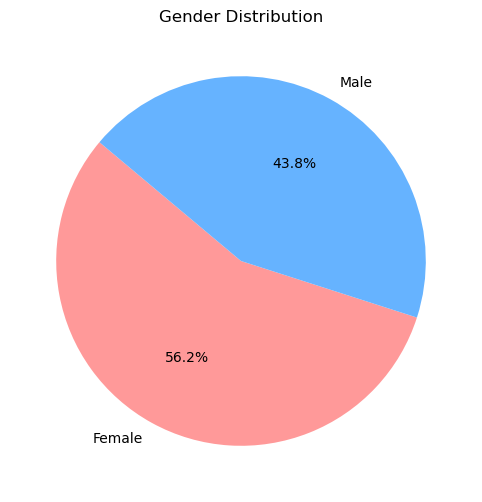

In [93]:
#To check if the proportion didnt change too much
gender_counts = data['Gender'].value_counts()

labels = ['Female', 'Male']
sizes = gender_counts

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=140)
plt.title('Gender Distribution')
plt.show()

In [94]:
data['Gender'] = label_encoder.fit_transform(data['Gender'])

### Sided

In [95]:
data["Sided"]

0        None
1       Right
2        Left
3        Left
4        Left
        ...  
417      None
418      Left
419       NaN
420      None
421      None
Name: Sided, Length: 422, dtype: object

In [96]:
# Get the existing non-NaN values in the 'Sided' column
existing_sides = data['Sided'].dropna()

data['Sided'] = data['Sided'].apply(
    lambda x: np.random.choice(existing_sides) if pd.isna(x) else x)

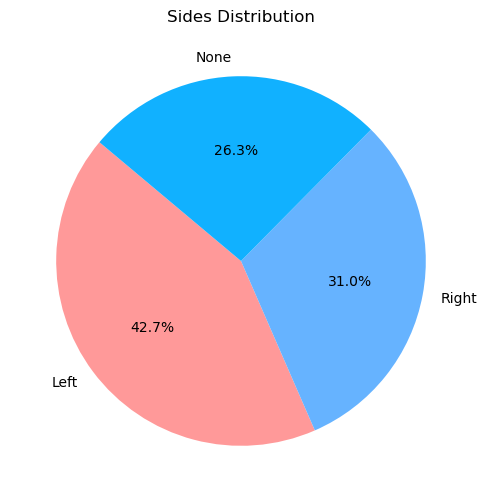

In [97]:
#To check sidedness
gender_counts = data['Sided'].value_counts()

labels = ['Left', 'Right', 'None']
sizes = gender_counts

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#11b1ff'], startangle=140)
plt.title('Sides Distribution')
plt.show()

In [98]:
data['Sided']


0        None
1       Right
2        Left
3        Left
4        Left
        ...  
417      None
418      Left
419      None
420      None
421      None
Name: Sided, Length: 422, dtype: object

In [99]:
data['Sided'] = label_encoder.fit_transform(data['Sided'])

In [100]:
data['Sided']


0      1
1      2
2      0
3      0
4      0
      ..
417    1
418    0
419    1
420    1
421    1
Name: Sided, Length: 422, dtype: int64

In [101]:
data["UPDRS"].value_counts()


UPDRS
Don't know    375
4              10
2               6
3               2
Name: count, dtype: int64

### Impact

I want to substitute everything that is not meaningful (Mild, Sever, Medium) to Unknown

In [102]:
print("Unique values in 'Impact':", data['Impact'].unique())


Unique values in 'Impact': ['  ------' ' Medium' ' Mild' ' Severe' ' ' nan ' ------']


In [103]:
data["Impact"].value_counts()

Impact
Mild       135
Medium     122
 ------     91
Severe      33
            11
------       1
Name: count, dtype: int64

In [104]:
impact_mapping = {
    "Unknown": 0,
    " Mild": 1,
    " Medium": 2,
    " Severe": 3
}

# Apply the mapping to the 'Impact' column
data['Impact'] = data['Impact'].map(impact_mapping)

# Verify the changes
print(data['Impact'].value_counts())


print("Unique values in 'Impact':", data['Impact'].unique())

Impact
1.0    135
2.0    122
3.0     33
Name: count, dtype: int64
Unique values in 'Impact': [nan  2.  1.  3.]


In [105]:
data['Impact'] = label_encoder.fit_transform(data['Impact'])

print("Unique values in 'Impact':", data['Impact'].unique())


Unique values in 'Impact': [3 1 0 2]


In [106]:
data["Impact"].value_counts()

Impact
0    135
3    132
1    122
2     33
Name: count, dtype: int64

### Convert the rest of non-numeric features

In [107]:
# Step 2: Check for non-numeric columns and convert them
for col in data.columns:
    if data[col].dtype == 'object':  # Check if the column is of type 'object'
        if col not in ['UserKey', 'Gender', 'Parkinsons']:  # Skip non-numeric columns
            data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, setting errors to NaN

print(f"Data shape after conversion: {data.shape}")

# Step 3: Fill missing values with the most frequent value in each column
for col in data.columns:
    mode_val = data[col].mode()
    if not mode_val.empty:
        data[col].fillna(mode_val[0], inplace=True)
    else:
        # Handle the case where mode is empty (no non-NaN values in the column)
        # You can choose to fill with a default value or skip
        data[col].fillna(0, inplace=True)  # or use another default value like NaN


Data shape after conversion: (422, 40)


/tmp/ipykernel_964/1791503564.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(mode_val[0], inplace=True)
/tmp/ipykernel_964/1791503564.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [108]:
data['Sided']

0      1
1      2
2      0
3      0
4      0
      ..
417    1
418    0
419    1
420    1
421    1
Name: Sided, Length: 422, dtype: int64

In [109]:
data["BirthYear"]

0      1942
1      1942
2      1946
3      1943
4      1965
       ... 
417    1952
418    1951
419    1947
420    1947
421    1994
Name: BirthYear, Length: 422, dtype: int64

In [110]:
print("Unique values in 'Impact':", data['Impact'].unique())


Unique values in 'Impact': [3 1 0 2]


## Correlation Matrix

/tmp/ipykernel_964/3371237419.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_corr.drop(columns=["UserKey", "Parkinsons", "Impact", "Levadopa", "DA","MAOB","Other","UPDRS", "DiagnosisYear"], inplace = True)  # Dropping 'UserKey' as it's not a feature


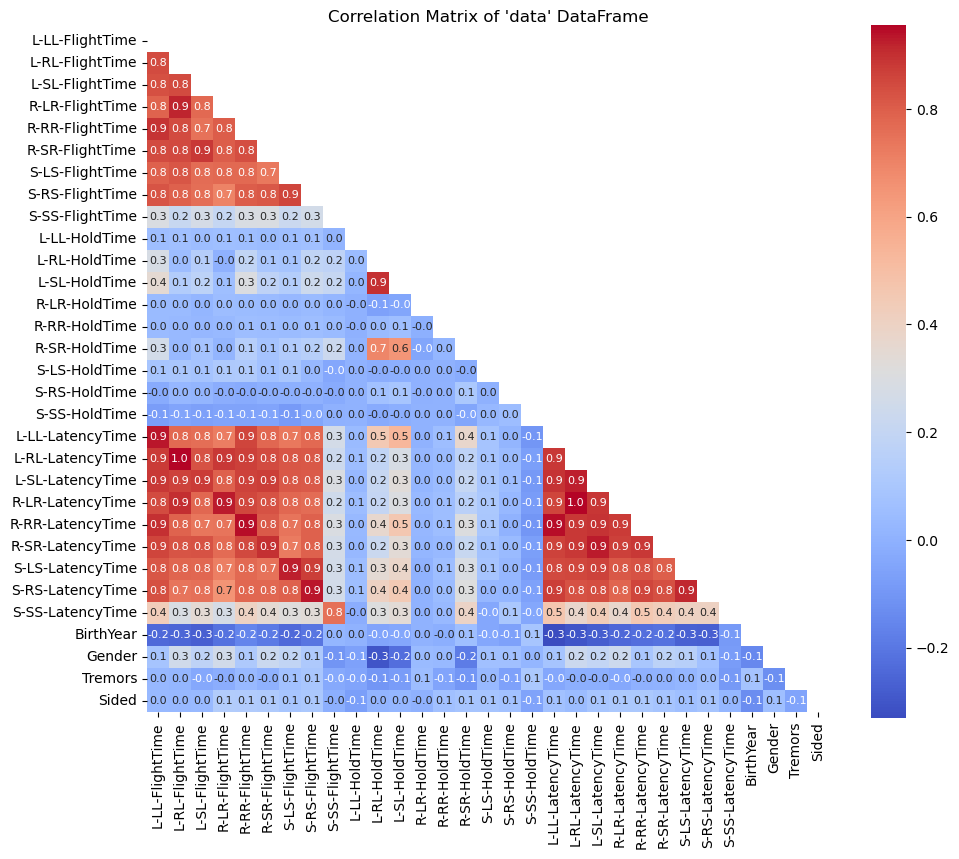

In [111]:
data_corr = data

label_encoder = LabelEncoder()
data_corr['Gender'] = label_encoder.fit_transform(data_corr['Gender'])
data_corr['Tremors'] = label_encoder.fit_transform(data_corr['Tremors'])
data_corr['Sided'] = label_encoder.fit_transform(data_corr['Sided'])



data_corr = data_corr[data_corr['Parkinsons'].isin([0, 1])]


# Step 5: Separate features (X) and target (y)
data_corr.drop(columns=["UserKey", "Parkinsons", "Impact", "Levadopa", "DA","MAOB","Other","UPDRS", "DiagnosisYear"], inplace = True)  # Dropping 'UserKey' as it's not a feature

corr_matrix = data_corr.corr()

# Step 2: Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Step 3: Plot the heatmap with reduced font size and masked lower triangle
plt.figure(figsize=(11, 9))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, mask=mask,
            annot_kws={"size": 8},  # Reduce the font size of the annotations
            square=True)  # Keep cells square-shaped
plt.title("Correlation Matrix of 'data' DataFrame")

plt.savefig("CorrMat")


plt.show()

In [112]:
print("Unique values in 'Sided':", data_corr['Sided'].unique())
print("Unique values in 'Gender':", data_corr['Gender'].unique())
print("Unique values in 'Tremors':", data_corr['Tremors'].unique())




Unique values in 'Sided': [1 2 0]
Unique values in 'Gender': [0 1]
Unique values in 'Tremors': [0 1]


In [113]:
data[data["UserKey"] == "MAKSYM0000"]

,UserKey,L-LL-FlightTime,L-RL-FlightTime,L-SL-FlightTime,R-LR-FlightTime,R-RR-FlightTime,R-SR-FlightTime,S-LS-FlightTime,S-RS-FlightTime,S-SS-FlightTime,...,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other,Parkinsons
421,MAKSYM0000,189.4208,124.586429,174.632667,101.4848,114.13381,252.660588,205.966897,190.259333,397.24,...,0,2016.0,1,4.0,3,0.0,0.0,0.0,0.0,0


Data shape after filling missing values: (422, 40)
Unique values in 'Sided': [1 2 0]
Unique values in 'Gender': [0 1]
Unique values in 'Tremors': [0 1 2]
Unique values in 'Parkinsons': [0 1 2]
Data shape after label encoding: (393, 40)
Training set shape: (432, 31), Test set shape: (118, 31)
Accuracy: 0.7966101694915254
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67        36
           1       0.85      0.85      0.85        82

    accuracy                           0.80       118
   macro avg       0.76      0.76      0.76       118
weighted avg       0.80      0.80      0.80       118



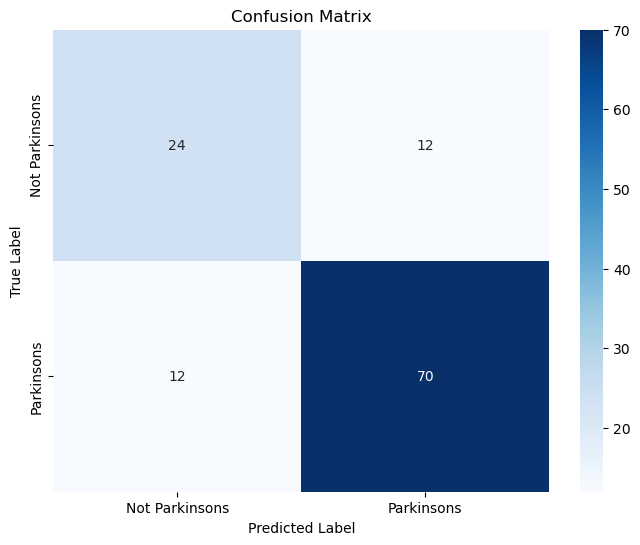

In [114]:
print(f"Data shape after filling missing values: {data.shape}")

# Step 4: Convert categorical data to numerical (Gender, Parkinsons)
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Parkinsons'] = label_encoder.fit_transform(data['Parkinsons'])
data['Tremors'] = label_encoder.fit_transform(data['Tremors'])
data['Sided'] = label_encoder.fit_transform(data['Sided'])

print("Unique values in 'Sided':", data['Sided'].unique())
print("Unique values in 'Gender':", data['Gender'].unique())
print("Unique values in 'Tremors':", data['Tremors'].unique())
print("Unique values in 'Parkinsons':", data['Parkinsons'].unique())


data = data[data['Parkinsons'].isin([0, 1])]

print(f"Data shape after label encoding: {data.shape}")

# Step 5: Separate features (X) and target (y)
X = data.drop(columns=["UserKey", "Parkinsons", "Impact", "Levadopa", "DA","MAOB","Other","UPDRS", "DiagnosisYear"])  # Dropping 'UserKey' as it's not a feature
y = data["Parkinsons"]

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")


# Step 7: Standardize the features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 8: Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Step 9: Make predictions and evaluate the model
y_pred = svm_model.predict(X_test)

# Step 10: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 11: Draw the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Parkinsons', 'Parkinsons'], 
            yticklabels=['Not Parkinsons', 'Parkinsons'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Applying 5-fold cross-validation

/tmp/ipykernel_964/777614063.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gender'] = label_encoder.fit_transform(data['Gender'])
/tmp/ipykernel_964/777614063.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Parkinsons'] = label_encoder.fit_transform(data['Parkinsons'])
/tmp/ipykernel_964/777614063.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Average Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.74      0.68        19
           1       0.91      0.87      0.89        60

    accuracy                           0.84        79
   macro avg       0.77      0.80      0.79        79
weighted avg       0.85      0.84      0.84        79



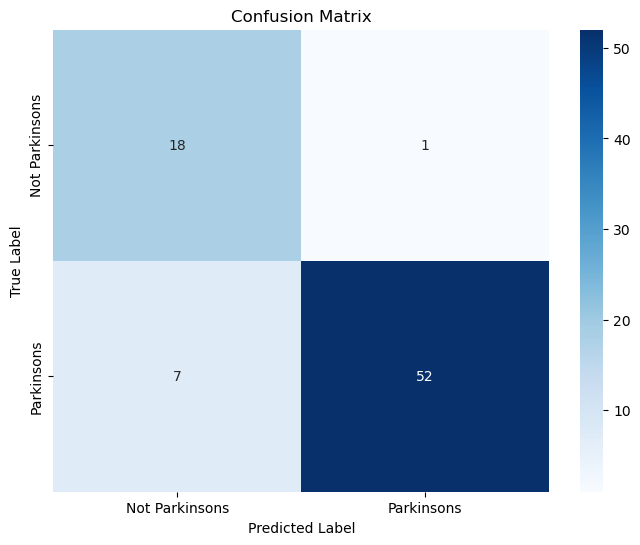

In [115]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 4: Convert categorical data to numerical (Gender, Parkinsons, Tremors, Sided)
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Parkinsons'] = label_encoder.fit_transform(data['Parkinsons'])
data['Tremors'] = label_encoder.fit_transform(data['Tremors'])
data['Sided'] = label_encoder.fit_transform(data['Sided'])

# Filter data to include only 0 and 1 in Parkinsons column
data = data[data['Parkinsons'].isin([0, 1])]

# Step 5: Separate features (X) and target (y)
X = data.drop(columns=["UserKey", "Parkinsons", "Impact", "Levadopa", "DA","MAOB","Other","UPDRS", "DiagnosisYear"])
y = data["Parkinsons"]

# Step 6: Apply Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
classification_reports = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Step 7: Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Step 8: Train the SVM model
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    # Step 9: Make predictions
    y_pred = svm_model.predict(X_test)

    # Step 10: Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    classification_reports.append(classification_report(y_test, y_pred))

# Print the average accuracy and classification report
print(f"Average Accuracy: {np.mean(accuracy_scores):.2f}")
print("Classification Report:\n", classification_reports[0])

# Step 11: Draw the confusion matrix for the last fold
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Parkinsons', 'Parkinsons'], 
            yticklabels=['Not Parkinsons', 'Parkinsons'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# If I am developing a population screening method, I want the false negatives to be penalized more than false positives. Since The false positives will eventually be diagnosed in a confirmatory revision

Data shape after filling missing values: (393, 40)
Data shape after label encoding: (393, 40)
Training set shape: (432, 31), Test set shape: (118, 31)
Accuracy: 0.8220338983050848
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.56      0.66        36
           1       0.83      0.94      0.88        82

    accuracy                           0.82       118
   macro avg       0.81      0.75      0.77       118
weighted avg       0.82      0.82      0.81       118



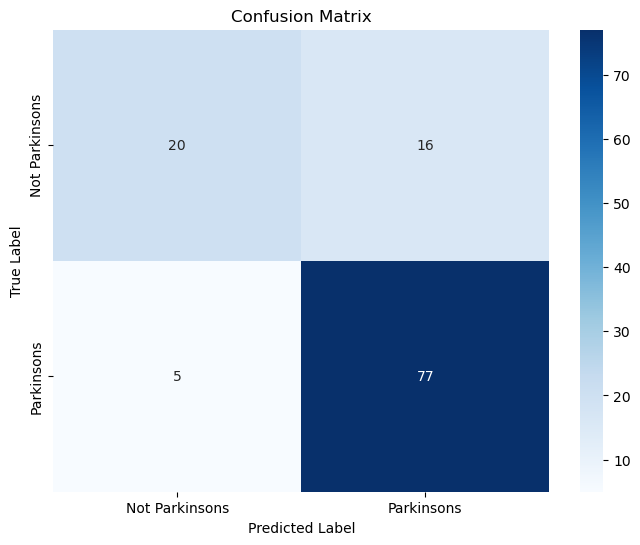

In [116]:
print(f"Data shape after filling missing values: {data.shape}")

# Step 4: Convert categorical data to numerical (Gender, Parkinsons)
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Parkinsons'] = label_encoder.fit_transform(data['Parkinsons'])
data['Tremors'] = label_encoder.fit_transform(data['Tremors'])
data['Sided'] = label_encoder.fit_transform(data['Sided'])


data = data[data['Parkinsons'].isin([0, 1])]

print(f"Data shape after label encoding: {data.shape}")

# Step 5: Separate features (X) and target (y)
X = data.drop(columns=["UserKey", "Parkinsons", "Impact", "Levadopa", "DA","MAOB","Other","UPDRS", "DiagnosisYear"])  # Dropping 'UserKey' as it's not a feature
y = data["Parkinsons"]

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")


# Step 7: Standardize the features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 8: Train the SVM model with adjusted class weights
svm_model = SVC(kernel='linear', class_weight={0: 1, 1: 2}, random_state=42)
svm_model.fit(X_train, y_train)

# Step 9: Make predictions and evaluate the model
y_pred = svm_model.predict(X_test)

# Step 10: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 11: Draw the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Parkinsons', 'Parkinsons'], 
            yticklabels=['Not Parkinsons', 'Parkinsons'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Same as before, but I drop columns that are more than 0.95 correlated

['L-RL-LatencyTime', 'R-LR-LatencyTime']
Data shape after dropping highly correlated columns: (393, 38)
Training set shape: (432, 29), Test set shape: (118, 29)
Accuracy: 0.8389830508474576
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.61      0.70        36
           1       0.85      0.94      0.89        82

    accuracy                           0.84       118
   macro avg       0.83      0.78      0.79       118
weighted avg       0.84      0.84      0.83       118



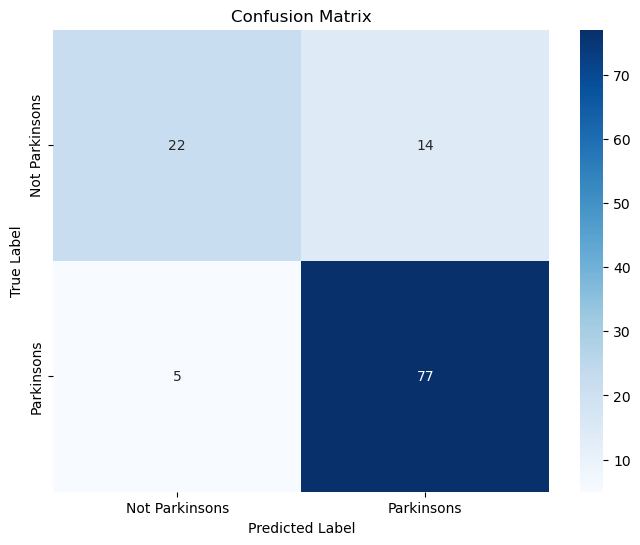

In [117]:
# Step 4: Compute the correlation matrix
corr_matrix = data_corr.corr().abs()

# Step 5: Identify highly correlated columns
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

# Drop only one column from each pair of highly correlated columns
data1 = data.drop(columns=to_drop)

print(f"Data shape after dropping highly correlated columns: {data1.shape}")

# Step 6: Separate features (X) and target (y)
X = data1.drop(columns=["UserKey", "Parkinsons", "Impact", "Levadopa", "DA","MAOB","Other","UPDRS", "DiagnosisYear"])  # Dropping 'UserKey' as it's not a feature
y = data1["Parkinsons"]

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Step 8: Standardize the features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 9: Train the SVM model with adjusted class weights
svm_model = SVC(kernel='linear', class_weight={0: 1, 1: 2}, random_state=42)
svm_model.fit(X_train, y_train)

# Step 10: Make predictions and evaluate the model
y_pred = svm_model.predict(X_test)

# Step 11: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 12: Draw the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Parkinsons', 'Parkinsons'], 
            yticklabels=['Not Parkinsons', 'Parkinsons'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Now, I drop MY data from dataset, train and test model and then predict if I have Parkinsons

In [118]:
# Step 4: Compute the correlation matrix
corr_matrix = data_corr.corr().abs()

# Step 5: Identify highly correlated columns
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]


# Drop only one column from each pair of highly correlated columns
data1 = data.drop(columns=to_drop)


maksym_row = data1[data1["UserKey"]== "MAKSYM0000"]

data1 = data1[data1["UserKey"]!= "MAKSYM0000"]
data1 = data1[data1["UserKey"]!= "FAKEAFM0000"]


# Step 6: Separate features (X) and target (y)
X = data1.drop(columns=["UserKey", "Parkinsons", "Impact", "Levadopa", "DA","MAOB","Other","UPDRS", "DiagnosisYear"])
y = data1["Parkinsons"]

array_certainty = []

for i in range(1,50):
    # Step 7: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=i)
    
    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=i)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    
    # Step 8: Standardize the features (important for SVM)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Step 9: Train the SVM model with adjusted class weights
    svm_model = SVC(kernel='linear',  class_weight={0: 1, 1: 2}, random_state=i)
    svm_model.fit(X_train, y_train)
    
    # Step 10: Make predictions and evaluate the model
    y_pred = svm_model.predict(X_test)

    """
    # Step 11: Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    
    # Step 12: Draw the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Parkinsons', 'Parkinsons'], 
                yticklabels=['Not Parkinsons', 'Parkinsons'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    """

    
    
    # Step 13: Predict the 'Parkinsons' value with certainty for the excluded row
    # Drop the same columns as before
    X_maksym = maksym_row.drop(columns=["UserKey", "Parkinsons", "Impact", "Levadopa", "DA","MAOB","Other","UPDRS", "DiagnosisYear"])
    
    # Standardize the features
    X_maksym = scaler.transform(X_maksym)
    
    # Get the decision function value
    maksym_decision = svm_model.decision_function(X_maksym)
    
    # Convert decision function output to probability-like value using sigmoid function
    from scipy.special import expit
    maksym_certainty = expit(maksym_decision)

    array_certainty.append(maksym_certainty[0])

print(np.mean(array_certainty))

Training set shape: (574, 29), Test set shape: (12, 29)
Training set shape: (578, 29), Test set shape: (12, 29)
Training set shape: (582, 29), Test set shape: (12, 29)
Training set shape: (576, 29), Test set shape: (12, 29)
Training set shape: (576, 29), Test set shape: (12, 29)
Training set shape: (578, 29), Test set shape: (12, 29)
Training set shape: (582, 29), Test set shape: (12, 29)
Training set shape: (578, 29), Test set shape: (12, 29)
Training set shape: (580, 29), Test set shape: (12, 29)
Training set shape: (576, 29), Test set shape: (12, 29)
Training set shape: (578, 29), Test set shape: (12, 29)
Training set shape: (580, 29), Test set shape: (12, 29)
Training set shape: (578, 29), Test set shape: (12, 29)
Training set shape: (578, 29), Test set shape: (12, 29)
Training set shape: (578, 29), Test set shape: (12, 29)
Training set shape: (582, 29), Test set shape: (12, 29)
Training set shape: (574, 29), Test set shape: (12, 29)
Training set shape: (576, 29), Test set shape: (

# PCA

In [119]:
print("Unique values in 'Impact':", data['Impact'].unique())


Unique values in 'Impact': [3 1 0 2]


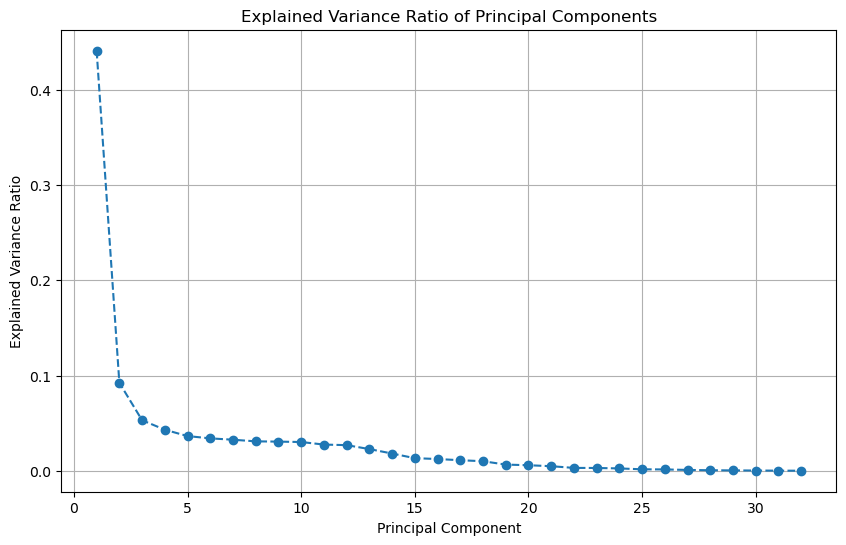

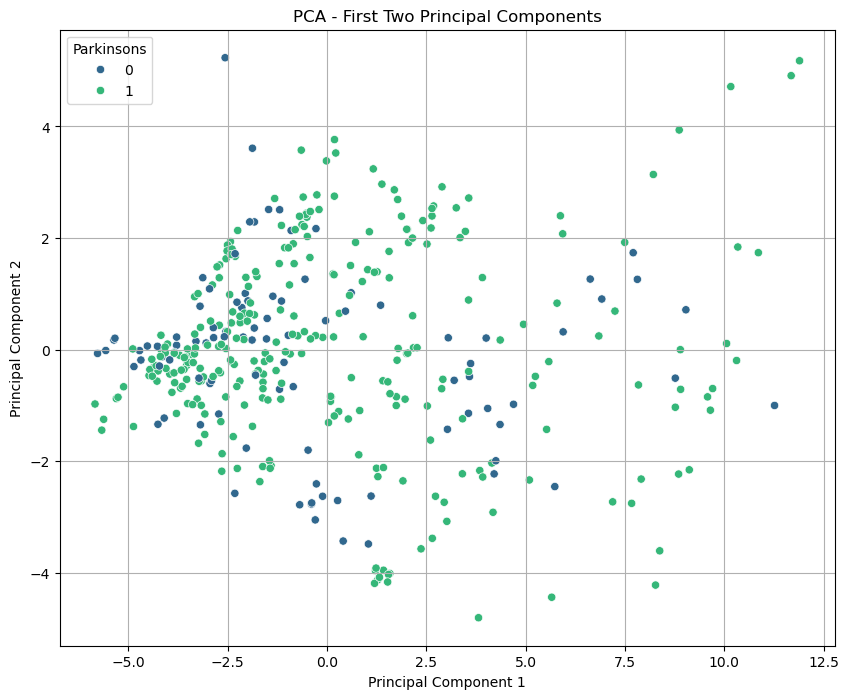

In [120]:
# Separate features (X) and target (y)
X = data.drop(columns=["UserKey", "Parkinsons", "Levadopa", "DA", "MAOB", "Other", "UPDRS", "DiagnosisYear"])  # Dropping 'UserKey' as it's not a feature

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 3: Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.grid()
plt.show()

# Step 4: Plot the first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Parkinsons'], palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.legend(title='Parkinsons')
plt.grid()
plt.show()

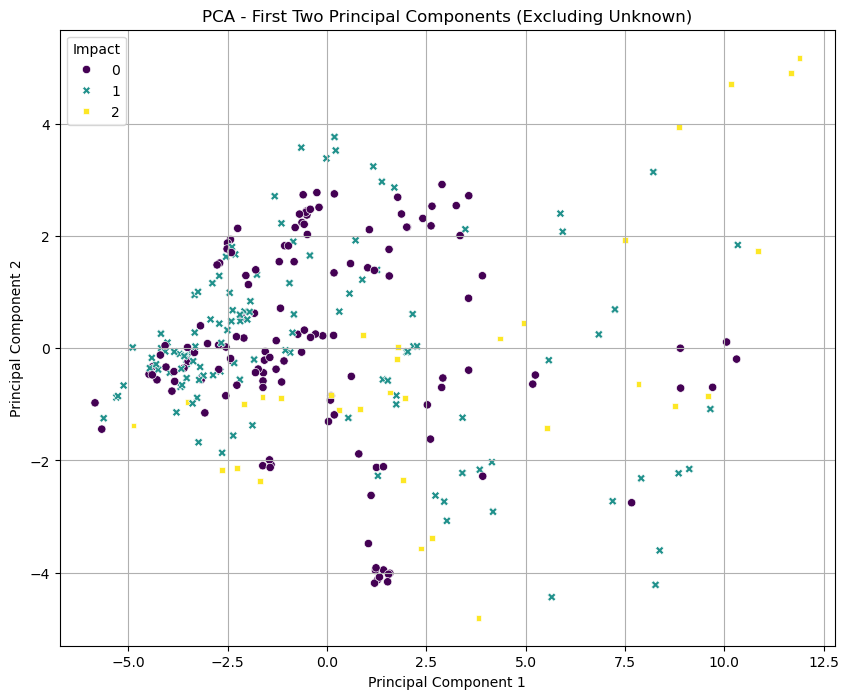

In [121]:
# Filter out instances where 'Impact' is 3 (Unknown)
filtered_data = data[data['Impact'] != 3]
X_pca_filtered = X_pca[data['Impact'] != 3]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_filtered[:, 0], y=X_pca_filtered[:, 1], hue=filtered_data['Impact'], palette='viridis', style=filtered_data['Impact'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components (Excluding Unknown)')
plt.legend(title='Impact')
plt.grid()
plt.show()

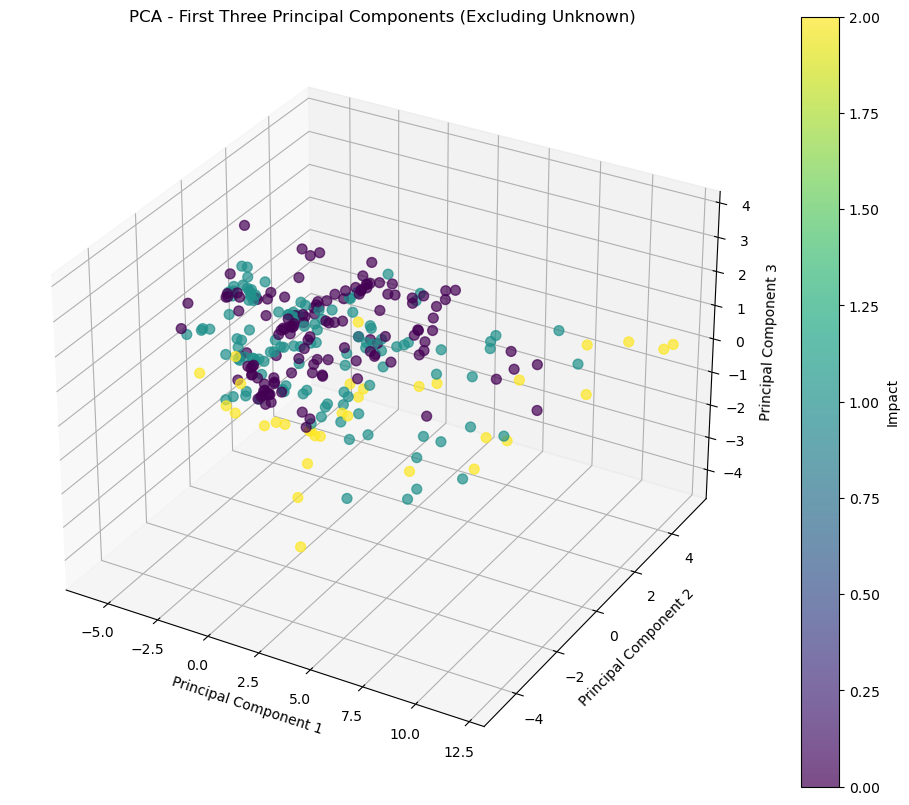

In [122]:
from mpl_toolkits.mplot3d import Axes3D

# Ensure you have the first three principal components
X_pca_filtered_3d = X_pca[data['Impact'] != 3, :3]

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_pca_filtered_3d[:, 0], X_pca_filtered_3d[:, 1], X_pca_filtered_3d[:, 2], 
                     c=filtered_data['Impact'], cmap='viridis', s=50, alpha=0.7)

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA - First Three Principal Components (Excluding Unknown)')

# Add color bar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Impact')

plt.show()

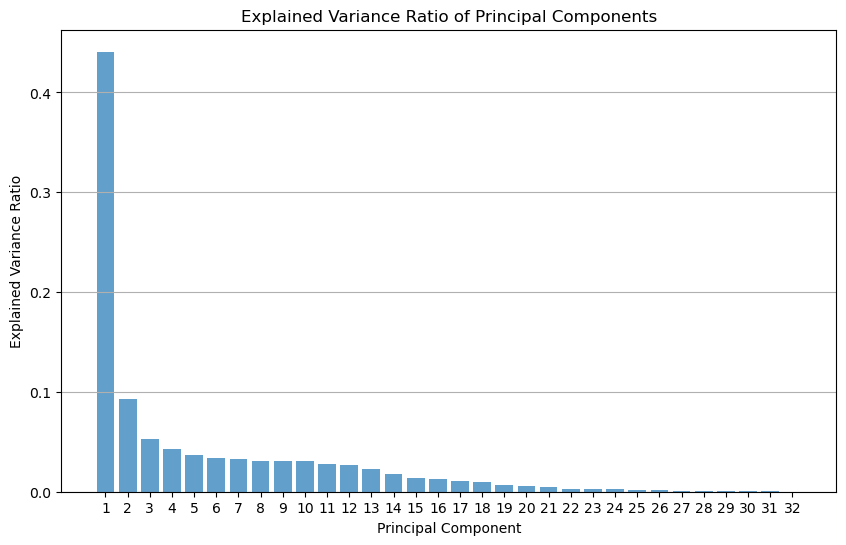

In [123]:
# Step 3: Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(axis='y')
plt.show()

In [124]:
feature_names = X.columns

# Get the PCA components
pca_components = pca.components_

# Create a DataFrame for the PCA components
components_df = pd.DataFrame(pca_components, columns=feature_names, index=[f'PC{i+1}' for i in range(len(pca_components))])

# Print the DataFrame to see the contributions
print("Contribution of Each Feature to Each Principal Component:")
print(components_df)




Contribution of Each Feature to Each Principal Component:
      L-LL-FlightTime  L-RL-FlightTime  L-SL-FlightTime  R-LR-FlightTime  \
PC1          0.250381         0.241106         0.232497         0.226796   
PC2          0.011087        -0.161700        -0.096709        -0.183788   
PC3          0.034796         0.007432        -0.008546        -0.029577   
PC4         -0.014737         0.008719         0.050578         0.040036   
PC5         -0.063462        -0.058013        -0.051668        -0.024598   
PC6         -0.009528         0.035857        -0.010825         0.031132   
PC7         -0.031871         0.038671         0.041896        -0.044026   
PC8         -0.005772        -0.003196        -0.031462        -0.016740   
PC9          0.015525        -0.006811        -0.016476         0.048766   
PC10         0.037328        -0.003136        -0.009767         0.012051   
PC11        -0.010381        -0.025170        -0.021122         0.042167   
PC12        -0.018476         

In [147]:
# Find the absolute loadings of the principal components for 'Impact' and 'Tremors'
impact_loadings = np.abs(components_df['Impact'])
tremors_loadings = np.abs(components_df['Tremors'])

# Find the index of the component with the maximum loading for 'Impact' and 'Tremors'
pc_impact_idx = impact_loadings.idxmax()
pc_tremors_idx = tremors_loadings.idxmax()

print(f'Principal Component most explained by "Impact": {pc_impact_idx}')
print(f'Principal Component most explained by "Tremors": {pc_tremors_idx}')

# If the same principal component is selected for both, find the second most explained component for 'Tremors'
if pc_impact_idx == pc_tremors_idx:
    # Find the second most explained component for 'Tremors'
    sorted_indices = tremors_loadings.sort_values(ascending=False).index
    # Find the second component (ensuring it's not the same as pc_tremors_idx)
    second_pc_tremors_idx = sorted_indices[1]
    pc_tremors_idx = second_pc_tremors_idx
    print(f'Principal Component for "Tremors" changed to the second most explained: {pc_tremors_idx}')

# Output the final components
print(f'Final Principal Component most explained by "Impact": {pc_impact_idx}')
print(f'Final Principal Component most explained by "Tremors": {pc_tremors_idx}')

Principal Component most explained by "Impact": PC3
Principal Component most explained by "Tremors": PC3
Principal Component for "Tremors" changed to the second most explained: PC16
Final Principal Component most explained by "Impact": PC3
Final Principal Component most explained by "Tremors": PC16


In [148]:
print(pc_impact_idx)

PC3


In [149]:
pc_impact_idx

'PC3'

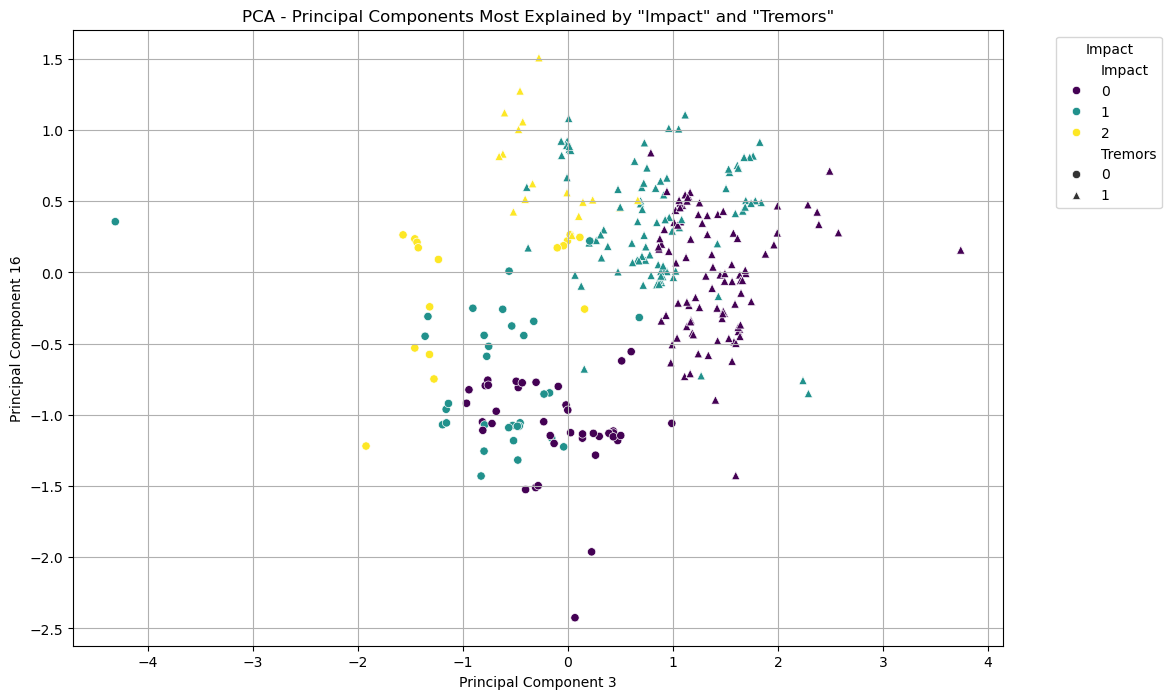

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the indices of the components
pc_impact_idx = int(str(pc_impact_idx.replace('PC', ''))) - 1
pc_tremors_idx = int(pc_tremors_idx.replace('PC', '')) - 1
if pc_impact_idx == pc_tremors_idx:
    pc_tremors_idx = int(second_pc_tremors_idx.replace('PC', '')) - 1



# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'PC_Impact': X_pca_filtered[:, pc_impact_idx],
    'PC_Tremors': X_pca_filtered[:, pc_tremors_idx],
    'Impact': filtered_data['Impact'],
    'Tremors': filtered_data['Tremors']
})

# Define markers for 'Tremors'
tremor_markers = {0: 'o', 1: '^'}  # Adjust marker values accordingly

# Plot the data
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC_Impact', y='PC_Tremors',
    hue='Impact', palette='viridis',
    style='Tremors', markers=tremor_markers,
    data=plot_data
)
plt.xlabel(f'Principal Component {pc_impact_idx + 1}')
plt.ylabel(f'Principal Component {pc_tremors_idx + 1}')
plt.title('PCA - Principal Components Most Explained by "Impact" and "Tremors"')
plt.legend(title='Impact', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


# What if I want to predict the impact?

In [129]:
data["Impact"]

0      3
1      1
2      1
3      0
4      1
      ..
416    1
417    1
418    0
420    3
421    3
Name: Impact, Length: 393, dtype: int64

In [130]:
# Step 1: Filter out instances where 'Impact' is 3 (Unknown)
data_filtered = data[data['Impact'] != 3]
data_filtered["Impact"]

1      1
2      1
3      0
4      1
6      2
      ..
414    0
415    1
416    1
417    1
418    0
Name: Impact, Length: 290, dtype: int64

Columns to drop due to high correlation: ['L-RL-LatencyTime']
Data shape after dropping highly correlated columns: (290, 30)
Training set shape: (273, 30), Test set shape: (87, 30)
Accuracy: 0.6436781609195402
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.70      0.68        44
           1       0.64      0.64      0.64        36
           2       0.50      0.29      0.36         7

    accuracy                           0.64        87
   macro avg       0.60      0.54      0.56        87
weighted avg       0.64      0.64      0.64        87



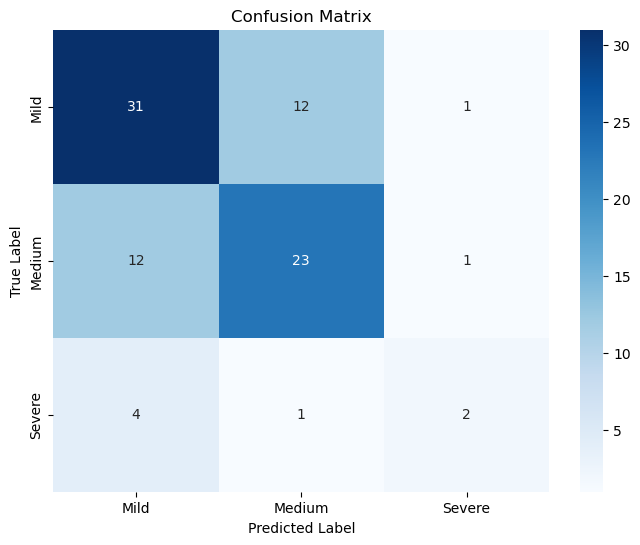

In [159]:
# Step 2: Update features (X) and target (y)
X = data_filtered.drop(columns=["UserKey", "Parkinsons", "Impact", "Levadopa", "DA", "MAOB", "Other", "UPDRS", "DiagnosisYear"])  # Dropping 'UserKey' as it's not a feature
y = data_filtered["Impact"]

# Step 3: Compute the correlation matrix
corr_matrix = X.corr().abs()

# Step 4: Identify highly correlated columns
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f'Columns to drop due to high correlation: {to_drop}')

# Drop only one column from each pair of highly correlated columns
X = X.drop(columns=to_drop)

print(f"Data shape after dropping highly correlated columns: {X.shape}")

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Step 6: Standardize the features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Train the SVM model with adjusted class weights
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Step 8: Make predictions and evaluate the model
y_pred = svm_model.predict(X_test)

# Step 9: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 10: Draw the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mild', 'Medium', 'Severe'], 
            yticklabels=['Mild', 'Medium', 'Severe'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
